In [3]:
!pip install matplotlib numpy torchvision tqdm


[notice] A new release of pip is available: 23.3.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip



=== Training Task 1 ===


100%|██████████| 198/198 [00:00<00:00, 538.37it/s]


Epoch 1, Loss: 0.2127


100%|██████████| 198/198 [00:00<00:00, 471.38it/s]


Epoch 2, Loss: 0.0348
Accuracy on Task 1: 0.999

=== Training Task 2 ===


100%|██████████| 189/189 [00:05<00:00, 36.67it/s]


Epoch 1, Loss: 0.4528


100%|██████████| 189/189 [00:04<00:00, 40.75it/s]


Epoch 2, Loss: 0.1545
Accuracy on Task 1: 0.969
Accuracy on Task 2: 0.961

=== Training Task 3 ===


100%|██████████| 176/176 [00:04<00:00, 40.43it/s]


Epoch 1, Loss: 0.4770


100%|██████████| 176/176 [00:04<00:00, 39.95it/s]


Epoch 2, Loss: 0.2267
Accuracy on Task 1: 0.609
Accuracy on Task 2: 0.906
Accuracy on Task 3: 0.943

=== Training Task 4 ===


100%|██████████| 191/191 [00:04<00:00, 40.10it/s]


Epoch 1, Loss: 0.1915


100%|██████████| 191/191 [00:04<00:00, 40.07it/s]


Epoch 2, Loss: 0.0615
Accuracy on Task 1: 0.618
Accuracy on Task 2: 0.852
Accuracy on Task 3: 0.882
Accuracy on Task 4: 0.982

=== Training Task 5 ===


100%|██████████| 185/185 [00:04<00:00, 40.23it/s]


Epoch 1, Loss: 0.4822


100%|██████████| 185/185 [00:04<00:00, 38.08it/s]


Epoch 2, Loss: 0.1814
Accuracy on Task 1: 0.526
Accuracy on Task 2: 0.622
Accuracy on Task 3: 0.511
Accuracy on Task 4: 0.967
Accuracy on Task 5: 0.939
=== Continual Learning Metrics ===
Average Accuracy (ACC):       0.7131
Forgetting (F):              0.3145
Backward Transfer (BWT):     -0.3145
Forward Transfer (FWT):      0.0000
Memory Usage:                153.71 MB
Computation Cost:            200 projections/batch
Plasticity-Stability Measure (PSM): 0.3427 (0-1 normalized)
=== Metrics (Split MNIST) ===
ACC=0.7131, F=0.3145, BWT=-0.3145, FWT=0.0000, Mem=153.71MB, PSM=0.3427


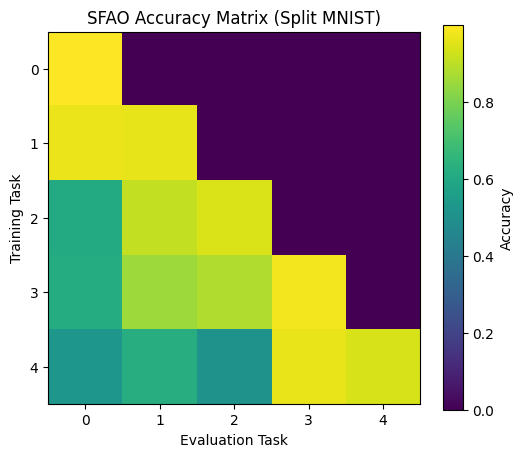

In [18]:
# Selective Forgetting-Aware Optimization (SFAO)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import random  # for monte carlo sampling

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, output_size=2):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.net(x.view(x.size(0), -1))


# SFAO Implementation (Updated Methods Only)
class SFAO:
    def __init__(self, model, lr=0.03, device='cuda',
                 max_memory=200, cosine_threshold=0.80, discard_threshold=-1e-4, sample_size=750):
        self.model = model.to(device)
        self.lr = lr
        self.device = device
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.S = []  # stored gradient vectors
        self.max_memory = max_memory
        self.cosine_threshold = cosine_threshold
        self.discard_threshold = discard_threshold
        self.sample_size = sample_size

    # flatten gradient
    def _flatten_grad(self):
        return torch.cat([p.grad.view(-1) for p in self.model.parameters() if p.grad is not None])

    # assign gradient
    def _assign_grad(self, flat_grad):
        idx = 0
        for p in self.model.parameters():
            if p.grad is not None:
                numel = p.numel()
                p.grad.copy_(flat_grad[idx:idx+numel].view_as(p))
                idx += numel

    # project new gradient against memory
    def _project_grad(self, g):
        if len(self.S) == 0: return g
        # sample some stored gradients
        sampled = self.S if len(self.S)<=self.sample_size else [self.S[i] for i in torch.randperm(len(self.S))[:self.sample_size]]
        max_cos = 0.0
        for v in sampled:
            cos_sim = torch.dot(g, v)/(torch.norm(g)*torch.norm(v)+1e-12)
            max_cos = max(max_cos, abs(cos_sim.item()))
           #max_cos = max(max_cos, cos_sim.item())
        if max_cos > self.cosine_threshold:
            return g  # do not project
        if max_cos < self.discard_threshold:
            return None
        g_proj = g.clone()
        for v in sampled:
            proj = (torch.dot(g_proj, v)/torch.dot(v,v))*v
            g_proj -= proj
        # discard tiny projected gradients
        if torch.norm(g_proj) < self.discard_threshold:
            return None
        return g_proj

    # one training step
    def observe(self, x, y, criterion=nn.CrossEntropyLoss()):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        loss = criterion(self.model(x), y)
        loss.backward()

        g = self._flatten_grad()
        g_proj = self._project_grad(g)
        if g_proj is not None:
            self._assign_grad(g_proj)
            self.optimizer.step()
        return loss.item()

    # store task gradients
    def end_task(self, dataloader, criterion=nn.CrossEntropyLoss()):
        self.model.eval()
        for x, y in dataloader:
            x, y = x.to(self.device), y.to(self.device)
            self.model.zero_grad()
            loss = criterion(self.model(x), y)
            loss.backward()
            g = self._flatten_grad()
            norm_g = g / (torch.norm(g)+1e-10)
            if len(self.S) >= self.max_memory:
                self.S.pop(0)
            self.S.append(norm_g.detach().clone())


# Prepare Split MNIST (5 tasks, 2 classes each)
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

def split_dataset(dataset, classes):
    idx = np.isin(dataset.targets.numpy(), classes)
    data = dataset.data[idx].float()/255.0
    targets = dataset.targets[idx]
    mapping = {cls:i for i,cls in enumerate(classes)}
    targets = torch.tensor([mapping[t.item()] for t in targets])
    return TensorDataset(data.view(-1, 28*28), targets)

task_classes = [[0,1],[2,3],[4,5],[6,7],[8,9]]
train_tasks = [split_dataset(mnist_train, c) for c in task_classes]
test_tasks = [split_dataset(mnist_test, c) for c in task_classes]

# Training with Metrics
num_tasks = len(train_tasks)
num_epochs = 2
batch_size = 64

model = SimpleMLP(input_size=784, hidden_size=256, output_size=2)
sfao = SFAO(model, lr=0.01, device=device)  # Changed from ogd to sfao

accuracy_matrix = np.zeros((num_tasks, num_tasks))

def evaluate_task(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

for task_id, train_dataset in enumerate(train_tasks):
    print(f"\n=== Training Task {task_id+1} ===")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Train
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in tqdm(train_loader):
            loss = sfao.observe(x, y)  # Changed from ogd.observe
            epoch_loss += loss
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Evaluate on all tasks seen so far
    for eval_id in range(task_id+1):
        test_loader = DataLoader(test_tasks[eval_id], batch_size=batch_size, shuffle=False)
        acc = evaluate_task(sfao.model, test_loader)  # Changed from ogd.model
        accuracy_matrix[task_id, eval_id] = acc
        print(f"Accuracy on Task {eval_id+1}: {acc:.3f}")

    # End of task: store gradient directions
    sfao.end_task(train_loader)  # Changed from ogd.end_task


# Compute Continual Learning Metrics
# Average Accuracy (ACC)
ACC = accuracy_matrix[-1].mean()  # Final row averaged across tasks

# Average Forgetting (F)
F = np.mean([
    np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j]
    for j in range(num_tasks-1)
])

# Backward Transfer (BWT)
BWT = np.mean([
    accuracy_matrix[-1, j] - accuracy_matrix[j, j]
    for j in range(num_tasks-1)
])

# Forward Transfer (FWT)
# Measures how much previous tasks helped the next task before it was trained
FWT = np.mean([
    accuracy_matrix[i, i+1]
    for i in range(num_tasks-1)
])

# Memory Usage (in MB)
num_params = sum(p.numel() for p in sfao.model.parameters())
mem_usage = len(sfao.S) * num_params * 4 / (1024**2)  # 4 bytes per float32

# 6. Computation Cost (Number of gradient projections per batch)
comp_cost = len(sfao.S)

# Plasticity-Stability Measure (PSM) - Normalized 0 to 1

# Define components
stability = 1 - F                 # High if forgetting is low
plasticity = max(FWT, 0)          # High if positive forward transfer

alpha = 0.5                       # Balance between stability and plasticity
PSM = alpha * stability + (1 - alpha) * plasticity

# Print Metrics
print("=== Continual Learning Metrics ===")
print(f"Average Accuracy (ACC):       {ACC:.4f}")
print(f"Forgetting (F):              {F:.4f}")
print(f"Backward Transfer (BWT):     {BWT:.4f}")
print(f"Forward Transfer (FWT):      {FWT:.4f}")
print(f"Memory Usage:                {mem_usage:.2f} MB")
print(f"Computation Cost:            {comp_cost} projections/batch")
print(f"Plasticity-Stability Measure (PSM): {PSM:.4f} (0-1 normalized)")

print("=== Metrics (Split MNIST) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage:.2f}MB, PSM={PSM:.4f}")

plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('SFAO Accuracy Matrix (Split MNIST)')
plt.show()



=== Training Task 1 ===


100%|██████████| 938/938 [00:02<00:00, 428.16it/s]


Epoch 1, Loss: 1.2255


100%|██████████| 938/938 [00:01<00:00, 469.76it/s]


Epoch 2, Loss: 0.4897
Accuracy on Task 1: 0.894

=== Training Task 2 ===


100%|██████████| 938/938 [00:24<00:00, 38.67it/s]


Epoch 1, Loss: 0.7620


100%|██████████| 938/938 [00:23<00:00, 39.57it/s]


Epoch 2, Loss: 0.4181
Accuracy on Task 1: 0.854
Accuracy on Task 2: 0.903

=== Training Task 3 ===


100%|██████████| 938/938 [00:23<00:00, 39.81it/s]


Epoch 1, Loss: 0.6654


100%|██████████| 938/938 [00:23<00:00, 39.24it/s]


Epoch 2, Loss: 0.3945
Accuracy on Task 1: 0.835
Accuracy on Task 2: 0.891
Accuracy on Task 3: 0.905
=== Metrics (Permuted MNIST) ===
ACC=0.8769, F=0.0358, BWT=-0.0358, FWT=0.0000, Mem=155.28MB, PSM=0.4821


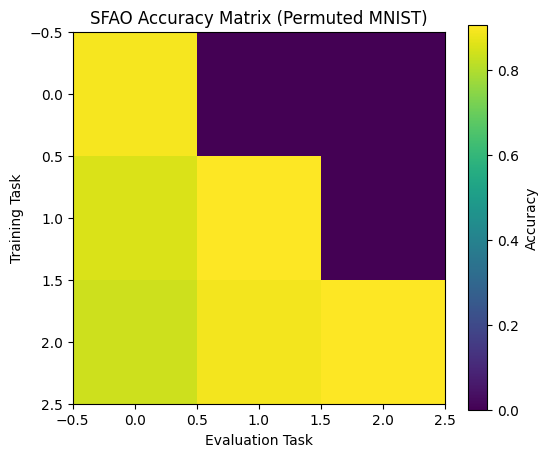

In [19]:
# =======================
# SFAO on Permuted  MNIST
# =======================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import random


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, output_size=10):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, x):
        return self.net(x.view(x.size(0), -1))

# SFAO Implementation (Updated Methods Only)
class SFAO:
    def __init__(self, model, lr=0.03, device='cuda',
                 max_memory=200, cosine_threshold=0.80, discard_threshold=-1e-4, sample_size=750):
        self.model = model.to(device)
        self.lr = lr
        self.device = device
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.S = []  # stored gradient vectors
        self.max_memory = max_memory
        self.cosine_threshold = cosine_threshold
        self.discard_threshold = discard_threshold
        self.sample_size = sample_size

    # flatten gradient
    def _flatten_grad(self):
        return torch.cat([p.grad.view(-1) for p in self.model.parameters() if p.grad is not None])

    # assign gradient
    def _assign_grad(self, flat_grad):
        idx = 0
        for p in self.model.parameters():
            if p.grad is not None:
                numel = p.numel()
                p.grad.copy_(flat_grad[idx:idx+numel].view_as(p))
                idx += numel

    # project new gradient against memory
    def _project_grad(self, g):
        if len(self.S) == 0: return g
        # sample some stored gradients
        sampled = self.S if len(self.S)<=self.sample_size else [self.S[i] for i in torch.randperm(len(self.S))[:self.sample_size]]
        max_cos = 0.0
        for v in sampled:
            cos_sim = torch.dot(g, v)/(torch.norm(g)*torch.norm(v)+1e-12)
            max_cos = max(max_cos, abs(cos_sim.item()))
           #max_cos = max(max_cos, cos_sim.item())
        if max_cos > self.cosine_threshold:
            return g  # do not project
        if max_cos < self.discard_threshold:
            return None
        g_proj = g.clone()
        for v in sampled:
            proj = (torch.dot(g_proj, v)/torch.dot(v,v))*v
            g_proj -= proj
        # discard tiny projected gradients
        if torch.norm(g_proj) < self.discard_threshold:
            return None
        return g_proj

    # one training step
    def observe(self, x, y, criterion=nn.CrossEntropyLoss()):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        loss = criterion(self.model(x), y)
        loss.backward()

        g = self._flatten_grad()
        g_proj = self._project_grad(g)
        if g_proj is not None:
            self._assign_grad(g_proj)
            self.optimizer.step()
        return loss.item()

    # store task gradients
    def end_task(self, dataloader, criterion=nn.CrossEntropyLoss()):
        self.model.eval()
        for x, y in dataloader:
            x, y = x.to(self.device), y.to(self.device)
            self.model.zero_grad()
            loss = criterion(self.model(x), y)
            loss.backward()
            g = self._flatten_grad()
            norm_g = g / (torch.norm(g)+1e-10)
            if len(self.S) >= self.max_memory:
                self.S.pop(0)
            self.S.append(norm_g.detach().clone())

# === Prepare 3 permuted MNIST tasks ===
num_tasks = 3
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_x = mnist_train.data.view(-1, 28*28).float()/255.0
test_x = mnist_test.data.view(-1, 28*28).float()/255.0
train_y = mnist_train.targets
test_y = mnist_test.targets

train_tasks, test_tasks = [], []
for _ in range(num_tasks):
    perm = torch.randperm(28*28)
    train_tasks.append(TensorDataset(train_x[:, perm], train_y))
    test_tasks.append(TensorDataset(test_x[:, perm], test_y))


# Training loop
num_epochs = 2
batch_size = 64
model = SimpleMLP()
sfao = SFAO(model, lr=0.01, device=device)
accuracy_matrix = np.zeros((num_tasks, num_tasks))

def evaluate_task(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

for task_id, train_dataset in enumerate(train_tasks):
    print(f"\n=== Training Task {task_id+1} ===")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in tqdm(train_loader):
            epoch_loss += sfao.observe(x, y)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Evaluate on all seen tasks
    for eval_id in range(task_id+1):
        test_loader = DataLoader(test_tasks[eval_id], batch_size=batch_size, shuffle=False)
        acc = evaluate_task(sfao.model, test_loader)
        accuracy_matrix[task_id, eval_id] = acc
        print(f"Accuracy on Task {eval_id+1}: {acc:.3f}")

    sfao.end_task(train_loader)

# === Metrics ===
ACC = accuracy_matrix[-1].mean()
F = np.mean([np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j] for j in range(num_tasks-1)]) if num_tasks>1 else 0.0
BWT = np.mean([accuracy_matrix[-1, j] - accuracy_matrix[j, j] for j in range(num_tasks-1)]) if num_tasks>1 else 0.0
FWT = np.mean([accuracy_matrix[i, i+1] for i in range(num_tasks-1)]) if num_tasks>1 else 0.0

num_params = sum(p.numel() for p in sfao.model.parameters())
mem_usage = len(sfao.S) * num_params * 4 / (1024**2)
comp_cost = len(sfao.S)
PSM = 0.5*(1-F) + 0.5*max(FWT,0)

print("=== Metrics (Permuted MNIST) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage:.2f}MB, PSM={PSM:.4f}")

plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('SFAO Accuracy Matrix (Permuted MNIST)')
plt.show()

Files already downloaded and verified
Files already downloaded and verified
Task 0: classes 0-9, train=5000, test=1000
Task 1: classes 10-19, train=5000, test=1000
Task 2: classes 20-29, train=5000, test=1000
Task 3: classes 30-39, train=5000, test=1000
Task 4: classes 40-49, train=5000, test=1000
Task 5: classes 50-59, train=5000, test=1000
Task 6: classes 60-69, train=5000, test=1000
Task 7: classes 70-79, train=5000, test=1000
Task 8: classes 80-89, train=5000, test=1000
Task 9: classes 90-99, train=5000, test=1000
Prepared 10 tasks (mode=permuted)

=== Training Task 1 ===


100%|██████████| 79/79 [00:00<00:00, 299.81it/s]


Epoch 1, Loss=2.2539


100%|██████████| 79/79 [00:00<00:00, 227.15it/s]


Epoch 2, Loss=2.1926
Accuracy on Task 1: 0.165

=== Training Task 2 ===


100%|██████████| 79/79 [00:01<00:00, 67.17it/s]


Epoch 1, Loss=2.3031


100%|██████████| 79/79 [00:01<00:00, 69.92it/s]


Epoch 2, Loss=2.2065
Accuracy on Task 1: 0.148
Accuracy on Task 2: 0.204

=== Training Task 3 ===


100%|██████████| 79/79 [00:02<00:00, 35.34it/s]


Epoch 1, Loss=2.2542


100%|██████████| 79/79 [00:02<00:00, 36.76it/s]


Epoch 2, Loss=2.0986
Accuracy on Task 1: 0.162
Accuracy on Task 2: 0.143
Accuracy on Task 3: 0.235

=== Training Task 4 ===


100%|██████████| 79/79 [00:02<00:00, 29.87it/s]


Epoch 1, Loss=2.3144


100%|██████████| 79/79 [00:02<00:00, 32.28it/s]


Epoch 2, Loss=2.1927
Accuracy on Task 1: 0.125
Accuracy on Task 2: 0.121
Accuracy on Task 3: 0.114
Accuracy on Task 4: 0.205

=== Training Task 5 ===


100%|██████████| 79/79 [00:02<00:00, 30.07it/s]


Epoch 1, Loss=2.2677


100%|██████████| 79/79 [00:02<00:00, 32.16it/s]


Epoch 2, Loss=2.1531
Accuracy on Task 1: 0.113
Accuracy on Task 2: 0.138
Accuracy on Task 3: 0.076
Accuracy on Task 4: 0.138
Accuracy on Task 5: 0.248

=== Training Task 6 ===


100%|██████████| 79/79 [00:02<00:00, 31.59it/s]


Epoch 1, Loss=2.2987


100%|██████████| 79/79 [00:02<00:00, 32.26it/s]


Epoch 2, Loss=2.1388
Accuracy on Task 1: 0.137
Accuracy on Task 2: 0.099
Accuracy on Task 3: 0.129
Accuracy on Task 4: 0.111
Accuracy on Task 5: 0.124
Accuracy on Task 6: 0.239

=== Training Task 7 ===


100%|██████████| 79/79 [00:02<00:00, 31.97it/s]


Epoch 1, Loss=2.1956


100%|██████████| 79/79 [00:02<00:00, 32.08it/s]


Epoch 2, Loss=2.0223
Accuracy on Task 1: 0.114
Accuracy on Task 2: 0.136
Accuracy on Task 3: 0.075
Accuracy on Task 4: 0.148
Accuracy on Task 5: 0.208
Accuracy on Task 6: 0.198
Accuracy on Task 7: 0.292

=== Training Task 8 ===


100%|██████████| 79/79 [00:02<00:00, 29.20it/s]


Epoch 1, Loss=2.2577


100%|██████████| 79/79 [00:02<00:00, 31.36it/s]


Epoch 2, Loss=2.1190
Accuracy on Task 1: 0.107
Accuracy on Task 2: 0.134
Accuracy on Task 3: 0.057
Accuracy on Task 4: 0.194
Accuracy on Task 5: 0.176
Accuracy on Task 6: 0.184
Accuracy on Task 7: 0.258
Accuracy on Task 8: 0.269

=== Training Task 9 ===


100%|██████████| 79/79 [00:02<00:00, 31.94it/s]


Epoch 1, Loss=2.2359


100%|██████████| 79/79 [00:02<00:00, 32.59it/s]


Epoch 2, Loss=2.1053
Accuracy on Task 1: 0.124
Accuracy on Task 2: 0.145
Accuracy on Task 3: 0.099
Accuracy on Task 4: 0.145
Accuracy on Task 5: 0.107
Accuracy on Task 6: 0.190
Accuracy on Task 7: 0.209
Accuracy on Task 8: 0.202
Accuracy on Task 9: 0.206

=== Training Task 10 ===


100%|██████████| 79/79 [00:02<00:00, 32.55it/s]


Epoch 1, Loss=2.2319


100%|██████████| 79/79 [00:02<00:00, 32.60it/s]


Epoch 2, Loss=2.0556
Accuracy on Task 1: 0.115
Accuracy on Task 2: 0.093
Accuracy on Task 3: 0.075
Accuracy on Task 4: 0.142
Accuracy on Task 5: 0.156
Accuracy on Task 6: 0.178
Accuracy on Task 7: 0.274
Accuracy on Task 8: 0.232
Accuracy on Task 9: 0.176
Accuracy on Task 10: 0.279
=== Metrics (Permuted CIFAR-100 CNN SFAO) ===
ACC=0.1720, F=0.0691, BWT=-0.0691, FWT=0.0000, Mem=816.95MB, PSM=0.4654


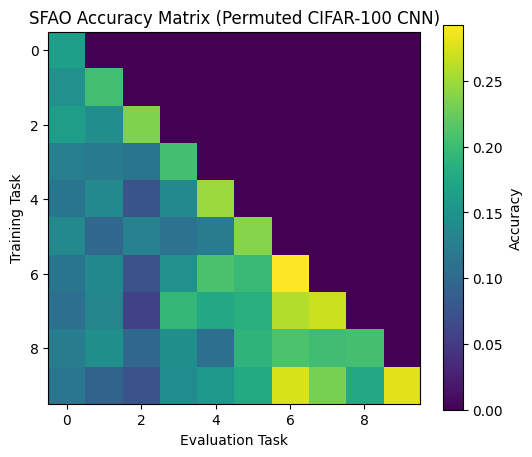

In [21]:
# === Cell: prepare CIFAR-100 tasks for SFAO (split or permuted) with CNN ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Hyperparameters ===
root = './data'
num_tasks = 10
num_classes = 100
classes_per_task = num_classes // num_tasks
batch_size = 64
download = True
mode = 'permuted'   # 'split' or 'permuted'
num_epochs = 2
learning_rate = 0.01

# CIFAR-100 mean/std for normalization
mean = torch.tensor([0.5071, 0.4867, 0.4408]).view(3, 1, 1)
std = torch.tensor([0.2675, 0.2565, 0.2761]).view(3, 1, 1)

# === Transforms ===
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()

# === Load datasets ===
train_ds = datasets.CIFAR100(root=root, train=True, download=download, transform=train_transform)
test_ds = datasets.CIFAR100(root=root, train=False, download=download, transform=test_transform)

# === Helper: extract subset tensors for a given set of class IDs ===
def extract_subset_tensors(dataset, class_list):
    targets = np.array(dataset.targets)
    mask = np.isin(targets, class_list)
    indices = np.nonzero(mask)[0].tolist()
    imgs, labs = [], []
    for i in indices:
        img, lbl = dataset[i]
        imgs.append(img)
        labs.append(lbl)
    return torch.stack(imgs), torch.tensor(labs, dtype=torch.long)

# === Prepare permutations if needed ===
permutations = []
if mode == 'permuted':
    rng = np.random.default_rng(42)
    for t in range(num_tasks):
        perm = rng.permutation(3 * 32 * 32).astype(np.int64)
        permutations.append(torch.tensor(perm, dtype=torch.long))

# === Build tasks ===
train_tasks, test_tasks = [], []
for t in range(num_tasks):
    cls_start = t * classes_per_task
    cls_end = cls_start + classes_per_task
    task_classes = list(range(cls_start, cls_end))

    x_train, y_train = extract_subset_tensors(train_ds, task_classes)
    x_test, y_test = extract_subset_tensors(test_ds, task_classes)

    # Apply permutation if required
    if mode == 'permuted':
        perm = permutations[t]
        N_train = x_train.shape[0]
        x_train = x_train.view(N_train, -1)[:, perm].view(N_train, 3, 32, 32)
        N_test = x_test.shape[0]
        x_test = x_test.view(N_test, -1)[:, perm].view(N_test, 3, 32, 32)

    # Normalize
    x_train = (x_train - mean) / std
    x_test = (x_test - mean) / std

    # Map labels to 0..(classes_per_task-1)
    class_map = {orig: i for i, orig in enumerate(task_classes)}
    y_train_mapped = torch.tensor([class_map[int(v)] for v in y_train])
    y_test_mapped = torch.tensor([class_map[int(v)] for v in y_test])

    # Store datasets (no flattening — CNN expects 3x32x32)
    train_tasks.append(TensorDataset(x_train, y_train_mapped))
    test_tasks.append(TensorDataset(x_test, y_test_mapped))

    print(f"Task {t}: classes {task_classes[0]}-{task_classes[-1]}, train={len(x_train)}, test={len(x_test)}")

print(f"Prepared {len(train_tasks)} tasks (mode={mode})")

# === CNN model ===
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x16x16
        x = self.pool(F.relu(self.conv2(x)))  # 64x8x8
        x = x.view(x.size(0), -1)             # flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)
        
# === SFAO class ===
# SFAO Implementation (Updated Methods Only)
class SFAO:
    def __init__(self, model, lr=0.03, device='cuda',
                 max_memory=200, cosine_threshold=0.80, discard_threshold=-1e-4, sample_size=750):
        self.model = model.to(device)
        self.lr = lr
        self.device = device
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.S = []  # stored gradient vectors
        self.max_memory = max_memory
        self.cosine_threshold = cosine_threshold
        self.discard_threshold = discard_threshold
        self.sample_size = sample_size

    # flatten gradient
    def _flatten_grad(self):
        return torch.cat([p.grad.view(-1) for p in self.model.parameters() if p.grad is not None])

    # assign gradient
    def _assign_grad(self, flat_grad):
        idx = 0
        for p in self.model.parameters():
            if p.grad is not None:
                numel = p.numel()
                p.grad.copy_(flat_grad[idx:idx+numel].view_as(p))
                idx += numel

    # project new gradient against memory
    def _project_grad(self, g):
        if len(self.S) == 0: return g
        # sample some stored gradients
        sampled = self.S if len(self.S)<=self.sample_size else [self.S[i] for i in torch.randperm(len(self.S))[:self.sample_size]]
        max_cos = 0.0
        for v in sampled:
            cos_sim = torch.dot(g, v)/(torch.norm(g)*torch.norm(v)+1e-12)
            max_cos = max(max_cos, abs(cos_sim.item()))
           #max_cos = max(max_cos, cos_sim.item())
        if max_cos > self.cosine_threshold:
            return g  # do not project
        if max_cos < self.discard_threshold:
            return None
        g_proj = g.clone()
        for v in sampled:
            proj = (torch.dot(g_proj, v)/torch.dot(v,v))*v
            g_proj -= proj
        # discard tiny projected gradients
        if torch.norm(g_proj) < self.discard_threshold:
            return None
        return g_proj

    # one training step
    def observe(self, x, y, criterion=nn.CrossEntropyLoss()):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        loss = criterion(self.model(x), y)
        loss.backward()

        g = self._flatten_grad()
        g_proj = self._project_grad(g)
        if g_proj is not None:
            self._assign_grad(g_proj)
            self.optimizer.step()
        return loss.item()

    # store task gradients
    def end_task(self, dataloader, criterion=nn.CrossEntropyLoss()):
        self.model.eval()
        for x, y in dataloader:
            x, y = x.to(self.device), y.to(self.device)
            self.model.zero_grad()
            loss = criterion(self.model(x), y)
            loss.backward()
            g = self._flatten_grad()
            norm_g = g / (torch.norm(g)+1e-10)
            if len(self.S) >= self.max_memory:
                self.S.pop(0)
            self.S.append(norm_g.detach().clone())

# === Training loop ===
sfao = SFAO(SimpleCNN(num_classes=classes_per_task), lr=learning_rate, device=device)
accuracy_matrix = np.zeros((num_tasks, num_tasks))

def evaluate_task(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

for task_id, train_dataset in enumerate(train_tasks):
    print(f"\n=== Training Task {task_id+1} ===")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in tqdm(train_loader):
            epoch_loss += sfao.observe(x, y)
        print(f"Epoch {epoch+1}, Loss={epoch_loss/len(train_loader):.4f}")

    # Evaluate on all seen tasks
    for eval_id in range(task_id+1):
        test_loader = DataLoader(test_tasks[eval_id], batch_size=batch_size, shuffle=False)
        acc = evaluate_task(sfao.model, test_loader)
        accuracy_matrix[task_id, eval_id] = acc
        print(f"Accuracy on Task {eval_id+1}: {acc:.3f}")

    sfao.end_task(train_loader)

# === Metrics ===
ACC = accuracy_matrix[-1].mean()
F = np.mean([np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j] for j in range(num_tasks-1)]) if num_tasks>1 else 0.0
BWT = np.mean([accuracy_matrix[-1, j] - accuracy_matrix[j, j] for j in range(num_tasks-1)]) if num_tasks>1 else 0.0
FWT = np.mean([accuracy_matrix[i, i+1] for i in range(num_tasks-1)]) if num_tasks>1 else 0.0
num_params = sum(p.numel() for p in sfao.model.parameters())
mem_usage = len(sfao.S) * num_params * 4 / (1024**2)
PSM = 0.5*(1-F) + 0.5*max(FWT,0)

print("=== Metrics (Permuted CIFAR-100 CNN SFAO) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage:.2f}MB, PSM={PSM:.4f}")

plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('SFAO Accuracy Matrix (Permuted CIFAR-100 CNN)')
plt.show()

In [3]:
# To make the unzip command below work 
!apt-get update && apt-get install -y unzip

Get:1 http://archive.ubuntu.com/ubuntu jammy InRelease [270 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]      
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:6 http://archive.ubuntu.com/ubuntu jammy/restricted amd64 Packages [164 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy/main amd64 Packages [1792 kB]     
Get:8 http://archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [17.5 MB] 
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1929 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [266 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [5299 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1575

In [ ]:
# === Cell: Prepare Split TinyImageNet tasks for SFAO (CNN) ===
import os
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
import random
from tqdm import tqdm

!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q /workspace/tiny-imagenet-200.zip -d /workspace/

In [ ]:
import os
print(os.listdir('/workspace/tiny-imagenet-200'))
print(os.listdir('/workspace/tiny-imagenet-200/train'))

In [4]:
# ===== Settings =====
root = '/workspace/tiny-imagenet-200' 
num_tasks = 10
num_classes = 200
classes_per_task = num_classes // num_tasks  # 20 per task
batch_size = 64
num_epochs = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ===== Transforms =====
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomCrop(64, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4802, 0.4481, 0.3975],
                         std=[0.2770, 0.2691, 0.2821])
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4802, 0.4481, 0.3975],
                         std=[0.2770, 0.2691, 0.2821])
])

# ===== Load datasets =====
train_ds = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
val_ds   = datasets.ImageFolder(os.path.join(root, 'val'), transform=test_transform)

# Map original class indices to sequential 0..199
class_to_idx = train_ds.class_to_idx
sorted_classes = sorted(class_to_idx.keys())
class_mapping = {class_to_idx[c]: i for i, c in enumerate(sorted_classes)}

train_labels = [class_mapping[label] for _, label in train_ds.samples]
val_labels   = [class_mapping[label] for _, label in val_ds.samples]

# Helper: get subset dataset for a class list
def subset_by_classes(dataset, labels, class_list):
    idxs = [i for i, lab in enumerate(labels) if lab in class_list]
    return Subset(dataset, idxs)

# ===== Create tasks =====
train_tasks, test_tasks = [], []
for t in range(num_tasks):
    cls_start = t * classes_per_task
    cls_end = cls_start + classes_per_task
    task_classes = list(range(cls_start, cls_end))
    train_tasks.append(subset_by_classes(train_ds, train_labels, task_classes))
    test_tasks.append(subset_by_classes(val_ds, val_labels, task_classes))
    print(f"Task {t}: Classes {cls_start}-{cls_end-1} | Train: {len(train_tasks[-1])}, Test: {len(test_tasks[-1])}")

# ===== Simple CNN for TinyImageNet =====
import torch.nn as nn
import torch.nn.functional as F

class TinyImageNetCNN(nn.Module):
    def __init__(self, num_outputs=20):  # default per task
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_outputs)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 64x32x32
        x = self.pool(F.relu(self.conv2(x)))  # 128x16x16
        x = self.pool(F.relu(self.conv3(x)))  # 256x8x8
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ===== SFAO setup =====
class SFAO:
    def __init__(self, model, lr=0.01, device='cuda'):
        self.model = model.to(device)
        self.lr = lr
        self.device = device
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.S = []  # Memory of gradient directions from previous tasks

    def _flatten_grad(self):
        return torch.cat([p.grad.view(-1) for p in self.model.parameters() if p.grad is not None])

    def _assign_grad(self, flat_grad):
        idx = 0
        for p in self.model.parameters():
            if p.grad is not None:
                numel = p.numel()
                p.grad.copy_(flat_grad[idx: idx+numel].view_as(p))
                idx += numel

    def _project_grad(self, g):
        if len(self.S) == 0:
            return g
        g_proj = g.clone()
        for v in self.S:
            proj = (torch.dot(g_proj, v) / torch.dot(v, v)) * v
            g_proj -= proj
        return g_proj

    # [Added method] Compute max cosine similarity between gradient g and sampled stored gradients
    def _cosine_similarity(self, sample, g):
        if len(sample) == 0:
            return 1.0
        max_sim = 0
        for v in sample:
            sim = torch.dot(g, v) / (torch.norm(g) * torch.norm(v))
            if sim > max_sim:
                max_sim = sim
        return max_sim

    # [Added method] Monte Carlo sample k gradients from stored memory without replacement
    def _monte_carlo(self, k):
        if len(self.S) <= k:
            return self.S
        else:
            return random.sample(self.S, k)

    # [Updated method] Selective projection based on cosine similarity threshold
    def observe(self, x, y, criterion=nn.CrossEntropyLoss(), threshold=0.80, sample_size=10):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        out = self.model(x)
        loss = criterion(out, y)
        loss.backward()

        g = self._flatten_grad()
        sample = self._monte_carlo(sample_size)
        max_sim = self._cosine_similarity(sample, g)

        if max_sim < threshold:
            g_orth = self._project_grad(g)
            self._assign_grad(g_orth)
        else:
            self._assign_grad(g)

        self.optimizer.step()
        return loss.item()

    def end_task(self, dataloader, criterion=nn.CrossEntropyLoss()):
        self.model.eval()
        for x, y in dataloader:
            x, y = x.to(self.device), y.to(self.device)
            self.model.zero_grad()
            out = self.model(x)
            loss = criterion(out, y)
            loss.backward()

            u = self._flatten_grad()
            u_proj = self._project_grad(u)
            norm_u_proj = u_proj / (u_proj.norm() + 1e-10)
            self.S.append(norm_u_proj.detach().clone())
            
accuracy_matrix = np.zeros((num_tasks, num_tasks))
sfao = SFAO(TinyImageNetCNN(classes_per_task), lr=0.01, device=device)

def evaluate_task(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

# ===== Training loop =====
for task_id, train_dataset in enumerate(train_tasks):
    print(f"\n=== Training Task {task_id+1} ===")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)
            epoch_loss += sfao.observe(x, y)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Evaluate on all seen tasks
    for eval_id in range(task_id+1):
        test_loader = DataLoader(test_tasks[eval_id], batch_size=batch_size, shuffle=False, num_workers=4)
        acc = evaluate_task(sfao.model, test_loader)
        accuracy_matrix[task_id, eval_id] = acc
        print(f"Accuracy on Task {eval_id+1}: {acc:.3f}")

    sfao.end_task(train_loader)

# ===== Metrics =====
ACC = accuracy_matrix[-1].mean()
F = np.mean([np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j] for j in range(num_tasks-1)]) if num_tasks>1 else 0.0
BWT = np.mean([accuracy_matrix[-1, j] - accuracy_matrix[j, j] for j in range(num_tasks-1)]) if num_tasks>1 else 0.0
FWT = np.mean([accuracy_matrix[i, i+1] for i in range(num_tasks-1)]) if num_tasks>1 else 0.0

num_params = sum(p.numel() for p in sfao.model.parameters())
mem_usage = len(sfao.S) * num_params * 4 / (1024**2)
PSM = 0.5*(1-F) + 0.5*max(FWT,0)

print("=== Metrics (Split TinyImageNet) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage:.2f}MB, PSM={PSM:.4f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('SFAO Accuracy Matrix (Split TinyImageNet)')
plt.show()

NameError: name 'os' is not defined